In [1]:
#importing required Libraries
import numpy as np
import os
from PIL import Image
import time
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
import torchvision as tv
from torchsummary import summary
from torchmetrics.classification import Accuracy
import lightning as Light
# import ignite
%matplotlib inline

c:\Users\varte\Documents\University\Year 4 Sem. 2\4442\LlamaOrDuck\venv\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# Chech if CUDA is working, set appropriate device
device = None
device_str = None
if torch.cuda.is_available():
    print("CUDA working \U0001F911")
    device_str = 'cuda'
    if('4060' in torch.cuda.get_device_name(0)):
        emoji = '\U0001F60D' 
    elif('GTX' in torch.cuda.get_device_name(0)):
           emoji = '\U0001F642'
    elif('TPU' in torch.cuda.get_device_name(0)):
           emoji = '\U0001F47D'
    else: emoji = '\U0001F601'
    print(f"This user has a {torch.cuda.get_device_name(0)} {emoji}") # flex your GPUs here
else:
    print("CUDA not working - running on CPU \U0001F480")
    device_str = 'cpu'
device = torch.device(device_str)


CUDA working 🤑
This user has a NVIDIA GeForce GTX 1650 Ti 🙂


In [ ]:
train_dataset_path = 'dataset/data/train'
test_dataset_path = 'dataset/data/test'
validation_dataset_path = 'dataset/data/val'

# colab = False
# if colab:
#   from google.colab import drive
#   colab_path = '/content/drive/MyDrive/Colab Notebooks/'
#   drive.mount('/content/drive')

#   train_dataset_path = colab_path+train_dataset_path
#   test_dataset_path = colab_path+test_dataset_path
#   validation_dataset_path = colab_path +validation_dataset_path

In [10]:
IMG_SIZE = (256,256)
training_transforms = tv.transforms.Compose([tv.transforms.Resize(IMG_SIZE), tv.transforms.ToTensor()])
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = training_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)

def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std

mean, std = get_mean_and_std(train_loader)

In [11]:
mean = mean[0]
std = std[0]

# We can use 3 input channels (r,g,b) or covert it to grayscale for 1 channel

# Some more filters we can apply for preprocessing
# .transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, fill=0)
# transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))

train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])
rgb_train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

rgb_test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

In [12]:
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)
validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = test_transforms)
rgb_train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = rgb_train_transforms)
rgb_test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = rgb_test_transforms)
rgb_validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = rgb_test_transforms)

dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset), 'test': len(test_dataset)}
print(train_dataset.class_to_idx)

{'animal duck': 0, 'llama': 1}


In [13]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = tv.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3352067..2.3989184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3352067..2.3989184].


labels:  tensor([0, 1, 0, 1, 0, 0])
labels:  tensor([1, 0, 1, 0, 0, 1])


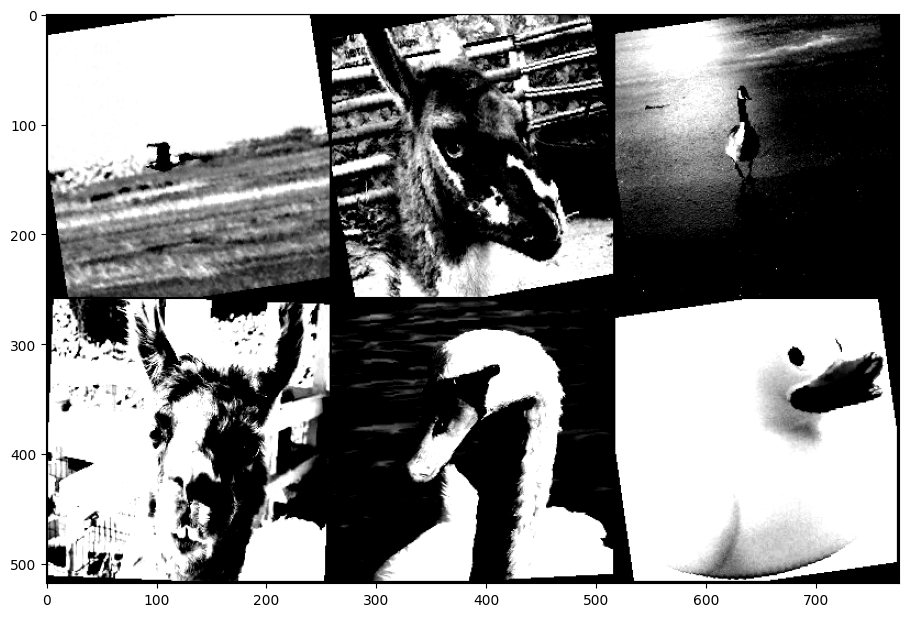

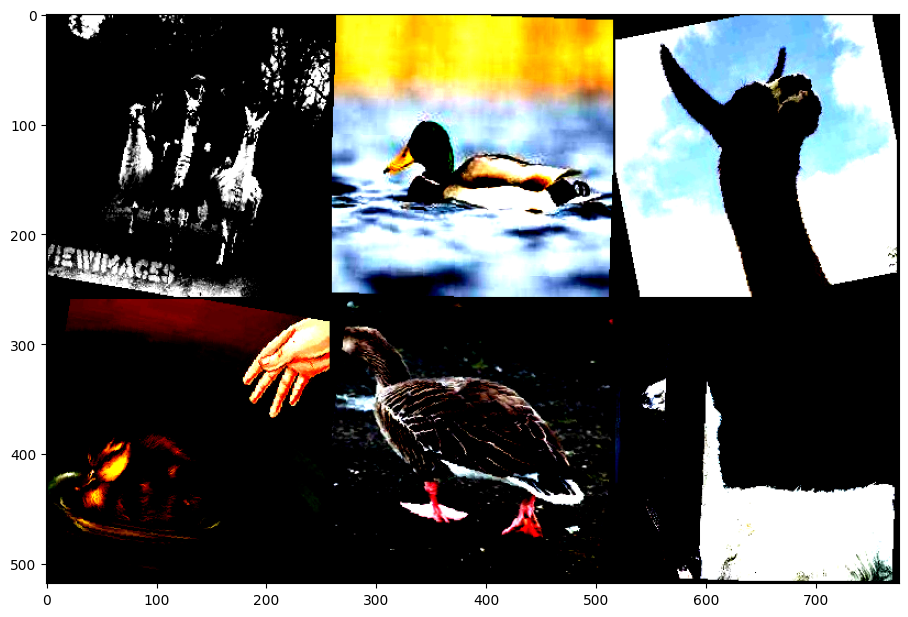

In [16]:
show_transformed_images(train_dataset)
show_transformed_images(rgb_train_dataset)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle=False)
rgb_train_loader = torch.utils.data.DataLoader(rgb_train_dataset, batch_size = 64, shuffle=True)
rgb_test_loader = torch.utils.data.DataLoader(rgb_test_dataset, batch_size = 64, shuffle=False)
rgb_validation_loader = torch.utils.data.DataLoader(rgb_validation_dataset, batch_size = 64, shuffle=False)

In [10]:
def accuracy(preds, y):
    _,preds = torch.max(preds, dim=1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))

In [ ]:
def evaluate(model, dataloader, criterion, optimizer):
    criterion=criterion.to(device)
    model.eval()
    preds = []
    y_true = []
    losses=[]
    accuracies = []
    running_corrects = 0
    running_loss = 0.0
    for X,y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  
        with torch.set_grad_enabled(True):
            yhat = model(X) 
            loss = criterion(yhat, y) 
            _, preds = torch.max(yhat, 1)
        loss = criterion(yhat, y)
        running_loss += loss.item() * X.size(0)
        running_corrects += torch.sum(preds == y.data)
    del model, dataloader,criterion
    return running_corrects, running_loss


def fit(model, model_name, criterion, optimizer, epochs=1, rgb=False, verbose=1):
    # define the loss function
    # determine the gradient descent algorithm to be used for updating weights

    curr_model = model.to(device)
    criterion = criterion.to(device)
    retry = 0
    correct_train_loader = rgb_train_loader if rgb else train_loader
    correct_validation_loader = rgb_validation_loader if rgb else validation_loader
    correct_test_loader = rgb_test_loader if rgb else test_loader
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(epochs)): 
        print(f'Epoch {epoch+1}/{epochs}')
        print('-=+=' * 10)
        running_loss=0.
        running_corrects = 0
        try:
            model.train()
            for X,y in correct_train_loader: 
                X, y = X.to(device), y.to(device)
                # print("predicting")
                optimizer.zero_grad()  
                with torch.set_grad_enabled(True):
                    yhat = curr_model(X) 
                    loss = criterion(yhat, y) 
                    _, preds = torch.max(yhat, 1)
                # print("done predicting")
                # backward prop for loss function and calculate gradients of all the layers in the net
                loss.backward()    
                # update the weights   
                optimizer.step() 

                running_loss += loss.item() * X.size(0)
                running_corrects += torch.sum(preds == y.data)
                
            # print("evaluating")    
            val_corrects, val_loss_sum = evaluate(model, correct_validation_loader, criterion, optimizer)
            #  TODO if val loss increasing or not improving, don't do more epochs?
            # print("done evaluating")   
            epoch_loss = running_loss / dataset_sizes["train"]
            epoch_acc = running_corrects.double() / dataset_sizes["train"]

            val_loss = val_loss_sum / dataset_sizes["val"]
            val_acc = val_corrects.double() / dataset_sizes["val"]
            if verbose>2: print(f"Epoch: {epoch} training loss is: {epoch_loss}, acc:{epoch_acc}")
            if verbose>1: print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}")

            # keep copy of best model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        except torch.cuda.OutOfMemoryError as e:
            print(e)
            if retry>2:
                break
            else:
                torch.cuda.empty_cache()
                retry+=1

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    # save best model so it doesnt need to be retrained
    model.load_state_dict(best_model_wts)
    # if(colab):
    #     torch.save(curr_model.state_dict(), f'{model_name}.pt') 
    # else:
    with open(model_name+'.pt', 'wb') as f: 
        torch.save(curr_model.state_dict(), f) 

    test_corrects, test_loss_sum = evaluate(model, correct_test_loader, criterion, optimizer)
    test_loss = test_loss_sum / dataset_sizes["test"]
    test_acc = test_corrects.double() / dataset_sizes["test"]
    if verbose: print(f"test Loss: {test_loss}, Accuracy: {test_acc}")
    del model, criterion
    torch.cuda.empty_cache()


In [12]:
densenet = tv.models.densenet121(weights=tv.models.DenseNet121_Weights.DEFAULT) #DenseNet121_Weights.DEFAULT - DenseNet121_Weights.IMAGENET1K_V1
num_classes = len(train_dataset.classes)  # In case we decide to add more classes
num_ftrs = densenet.classifier.in_features
densenet.classifier = torch.nn.Linear(num_ftrs, num_classes)


In [ ]:
class Gray_CNN1(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)), #input of 1 channel, change first number to 3 for rgb 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), # drop 20% of values
            torch.nn.MaxPool2d(2,2), # get max value from (2,2) square -> halve the width and height of feature matrix
            torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=1), 
            torch.nn.ReLU(),
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 125 * 125, 128), 
            # 248 because we start from 256 and each conv2d layer removes 2 columns and rows b/c no padding and 3x3 kernel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x): 
        return self.model(x)
    

class Gray_CNN1_64(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)), #input of 1 channel, change first number to 3 for rgb 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), # drop 20% of values
            torch.nn.MaxPool2d(2,2), # get max value from (2,2) square -> halve the width and height of feature matrix
            torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=1), 
            torch.nn.ReLU(),
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 29 * 29, 128), 
            # 248 because we start from 256 and each conv2d layer removes 2 columns and rows b/c no padding and 3x3 kernel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x): 
        return self.model(x)
    
summary(Gray_CNN1().to(device), input_size=(1, IMG_SIZE[0],IMG_SIZE[1]), device=device_str)
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             320
              ReLU-2           [-1, 32, 62, 62]               0
           Dropout-3           [-1, 32, 62, 62]               0
         MaxPool2d-4           [-1, 32, 31, 31]               0
            Conv2d-5           [-1, 32, 29, 29]           9,248
              ReLU-6           [-1, 32, 29, 29]               0
           Flatten-7                [-1, 26912]               0
            Linear-8                  [-1, 128]       3,444,864
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 2]             258
Total params: 3,454,690
Trainable params: 3,454,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 3.67
Params size (MB): 13.18
Estima

In [ ]:
# model_name= "densenet121"
# curr_model = densenet
model_name= "GrayCNN1_64"
curr_model = Gray_CNN1_64()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(curr_model.parameters(), lr = 1e-3)
# TODO add scheduler?
 
# open a previously trained model
try:
    with open(model_name+'.pt', 'rb') as f:
        curr_model.load_state_dict(torch.load(f))  
except FileNotFoundError:
    print("Model does not exist yet")
    
fit(model=curr_model, model_name=model_name, criterion=criterion, optimizer=optimizer, epochs = 3, rgb=False, verbose = 1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 33%|███▎      | 1/3 [00:03<00:07,  3.73s/it]

Epoch 2/3
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 67%|██████▋   | 2/3 [00:07<00:03,  3.50s/it]

Epoch 3/3
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


100%|██████████| 3/3 [00:10<00:00,  3.48s/it]


Training complete in 0m 10s
Best val Acc: 0.8017
test Loss: 0.5349955249745934, Accuracy: 0.7414500683994528
